### Goals:

- Write a discrete time, stochastic simulation of individuals dispersing across a landscape over many generations so that they follow the porous medium equation, 
$$\frac{d}{dt} u(x,t) = \frac{\sigma^2}{2}\frac{d^2}{dx^2}(u(x,t)^2) + u(x, t)(1-u(x,t))$$
- Test if the distribution of simulated locations, $u(x, t)$, approximately satisfies the equation.

$u(x,t)$ is population per unit length

### SLiM Simulation

See *pme_1d.slim*

Individuals start out on one side of the landscape.

Each generation, each individual:

- produces a single offspring with probability $1-e^{− dt\gamma}$, and then
- dies with probability $1−e^{− dt\mu}$

where $\gamma = N/K$ and $\mu = 2N/K - 1$.

$N$ is the local population density around the individual.

Offspring disperse from the parent, dispersal distance is drawn from a normal distribution with mean 0 and variance $\sigma^2$

We used $1-exp(-dt\gamma)$ as the probability of producing a single offspring because:

- When using $N/K$ the population was unstable at large N, because every individual can only die once, but can have an unlimited number of offspring
- Using $1-exp(-dt\gamma)$ caps the birth rate at 1
- $(N/K) dt \approx (1-exp(-dtN/K))$

### Test if the locations follow the PME

1. Estimate $u(x, t)$ from the simulated locations
2. Calculate discrete approximations of $\frac{d}{dt} \widehat{u(x,t)}$ and  $\frac{d^2}{dx^2} \left(\widehat{u(x,t)}^2 \right)$

### Reasons simulated locations might not follow the PME

1. Edge effects
2. Discretization of time
3. Discretization of space in computing derivatives
4. Using differential equation instead of integral
5. Too much demographic noise
6. Coding error

In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
#! ~/build/slim -d 'OUTPATH="pme_1d.trees"' pme_1d.slim

In [3]:
# Results
ts = pyslim.load("pme_1d.trees")

Find the values of $\sigma$, $dt$, and $K$ used in the simulation.

In [4]:
sigma = ts.metadata['SLiM']['user_metadata']['DISPERSAL_SIGMA'][0]
dt = ts.metadata['SLiM']['user_metadata']['DT'][0]
K = ts.metadata['SLiM']['user_metadata']['K'][0]

In [5]:
max_x = round(max(ts.individual_locations[:,0]))
max_y = max(ts.individual_locations[:,1])
min_y = min(ts.individual_locations[:,1])
max_t = max(ts.individual_times)

print(max_x, max_y, min_y, max_t)

20 100000000.0 -7.953031540099203e+306 499.0



## Estimating $u$ and calculating discrete derivatives

$h$ - size of $x$ bins

$\widehat{u_t(x)} = \frac{\text{population size between } x \text{ and } x + h \text{ at time } t}{hK}$

$\frac{d}{dt} \widehat{u_t(x)} \approx (\widehat{u(x, t)} - \widehat{u(x, t - dt)})/dt$

$\frac{d^2}{dx^2} \widehat{u(x,t)^2} \approx \frac{\widehat{\frac{d}{dx}u(x + h/2, t)^2} - \widehat{\frac{d}{dx}u(x- h/2, t)^2}}{h} = \frac{\frac{\widehat{u(x + h, t)^2} - \widehat{u(x, t)^2}}{h} - \frac{\widehat{u(x, t)^2} - \widehat{u(x - h, t)^2}}{h}}{h} = \frac{\widehat{u(x + h, t)^2} - 2\widehat{u(x, t)^2} + \widehat{u(x - h, t)^2}}{h^2}$

In [6]:
h = 0.8
y_bins = [min_y, max_y]
x_bins = np.arange(0, round(max_x)+h, h)
t_bins = np.arange(0, max_t + 1)

# Population sizes for each time step within each x bin
popsize = pyslim.population_size(ts, x_bins, y_bins, t_bins)

In [7]:
# Estimate u
uhat = popsize[:,0, :]/(K*h)

print(np.shape(uhat))
print(len(x_bins))
print(len(t_bins))

(25, 499)
26
500


`uhat` is a $n_x$ = `len(x_bins) - 1` by $n_t$ = `len(t_bins) - 1` grid.

$d/dt$ `uhat` between `x_bins[i]` and `x_bins[i + 1]` and  `t_bins[j]` and `t_bins[j + 1]` $\approx$ `uhat[i, j -1] - uhat[i, j]`

So I can calculate $d/dt$ for $i = 0, 1, ..., n_x -1$ and $j = 1, 2, ..., n_t - 1$

$d^2/dx^2$ `uhat` between `x_bins[i]` and `x_bins[i + 1]` and  `t_bins[j]` and `t_bins[j + 1]` $\approx$ `(uhat[i + 1, j]**2 - 2*uhat[i, j] + uhat[i - 1, j])/h**2`

So I can calculate $d^2/dx^2$ for $i = 1, ..., n_x - 2$ and $j = 0, 1, 2, ..., n_t - 1$

And both for $i = 1, ..., n_x - 2$ and $j = 1, 2, ..., n_t - 1$



In [8]:
# Compute left and right hand sides of the PME for each x and each time step using discrete derivatives
# Store each in an array, first axis is x, second axis is time

nx = np.shape(uhat)[0]
nt = np.shape(uhat)[1]

i_vals = np.arange(1, nx - 1)
j_vals = np.arange(1, nt)

x_vals = np.empty([len(i_vals),len(j_vals)])
t_vals = np.empty([len(i_vals),len(j_vals)])

lhs = np.empty([len(i_vals),len(j_vals)])
rhs = np.empty([len(i_vals),len(j_vals)])

for i_index, i in enumerate(i_vals):
    for j_index, j in enumerate(j_vals):
        x = x_bins[i]
        t = t_bins[j]
        
        uhatt = uhat[i, j]
        uhattm1  = uhat[i, j-1]
        
        ddt = (uhattm1 - uhatt)
    
        d2dx2 = (uhat[i + 1, j]**2 - 2*uhat[i, j]**2 + uhat[i - 1, j]**2)/h**2
    
        x_vals[i_index, j_index] = x
        t_vals[i_index, j_index] = t   
    
        lhs[i_index, j_index] = ddt
        #rhs[index] = dt*((sigma**2/2)*d2dx2 + uhatt*(1 - uhatt))
        # birth minus death instead
        rhs[i_index, j_index] = dt*(sigma**2/2)*d2dx2 + uhatt*(np.exp(-dt*(2*uhatt - 1)) - np.exp(-dt*uhatt)) 

In [9]:
np.shape(lhs)

(23, 498)

In [10]:
print(lhs[:,5])

[-0.009375  0.       -0.028125  0.015625  0.00625  -0.021875  0.053125
 -0.040625 -0.00625  -0.003125 -0.0125    0.003125  0.01875  -0.009375
  0.        0.       -0.0125   -0.0125   -0.003125  0.009375  0.015625
 -0.009375 -0.00625 ]


## Plot of $\hat{u}$

You can see that the population starts on the left and moves to the right. In the initial generation, the population density is about 1 from 0 to 5 and drops to zero at 5, and over the rest of the generations the point where $\hat{u}$ drops to zero moves to the right.

### For the initial generation

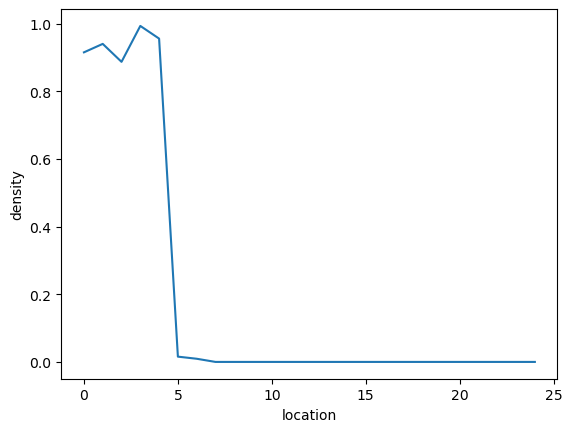

In [11]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(uhat[:,-1])
ax1.set_xlabel("location")
ax1.set_ylabel("density")
plt.show()

### For more generations

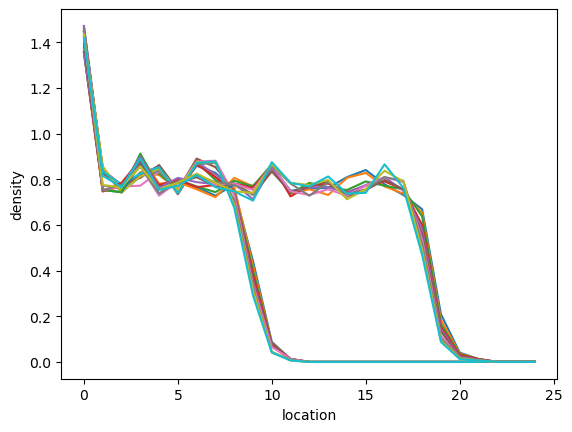

In [12]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(uhat[:,-100:-90])
ax1.plot(uhat[:,-300:-290])
ax1.set_xlabel("location")
ax1.set_ylabel("density")
plt.show()

# There are edge effects

### LHS of PME vs RHS

We want a cloud of points around the $y=x$ line.

In [13]:
print(sigma)

0.8


In [14]:
# Sum over all locations

# Without edges
#sum_lhs = np.sum(lhs[3:-3,:-50], axis = 0)
#sum_rhs = np.sum(rhs[3:-3,:-50], axis = 0)

sum_lhs = np.sum(lhs, axis = 0)
sum_rhs = np.sum(rhs, axis = 0)

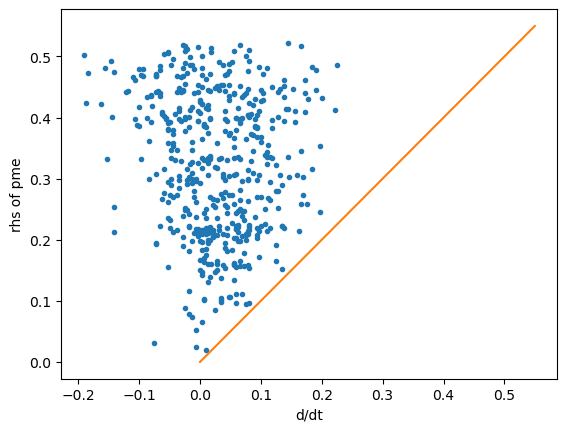

In [15]:
fig, ax = plt.subplots()
ax.plot(sum_lhs, sum_rhs, '.')
ax.plot([0, 0.55], [0, 0.55])
ax.set_xlabel("d/dt")
ax.set_ylabel("rhs of pme")
plt.show()